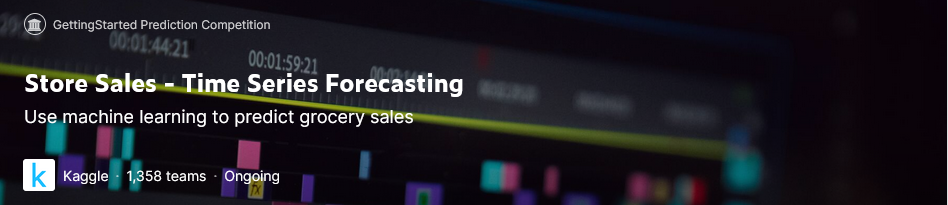

### Продажи в магазине - прогнозирование временных рядов
#### ML для прогнозирования продаж продуктов

В этом соревновании вы будете прогнозировать продажи тысяч семейств продуктов, продаваемых в магазинах Favorita, расположенных в Эквадоре. Данные обучения включают даты, информацию о магазине и продукте, информацию о том, рекламировался ли этот товар, а также количество продаж. Дополнительные файлы содержат дополнительную информацию, которая может быть полезна при создании моделей.

[Соревнование](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=transactions.csv)

Метрика, которая будет использоваться для оценки прогноза
- Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE)

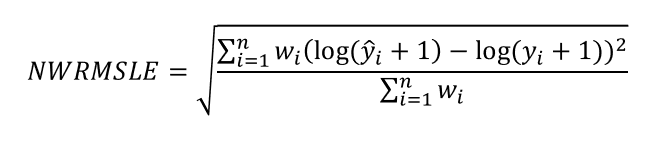

где w - веса продуктов (1,25 для скоропортящихся, 1 для остальных)
___

In [24]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
stores = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
stores.shape

(54, 5)

In [8]:
holidays_events = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\holidays_events.csv')
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [12]:
oil = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\oil.csv')
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [13]:
sample_submission = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\sample_submission.csv')
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [15]:
test = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\test.csv')
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [16]:
train = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\train.csv')
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [17]:
transactions = pd.read_csv(r'C:\Users\admin\jupyter_notebook\kaggle\Store_sales\transactions.csv')
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


<AxesSubplot:xlabel='date'>

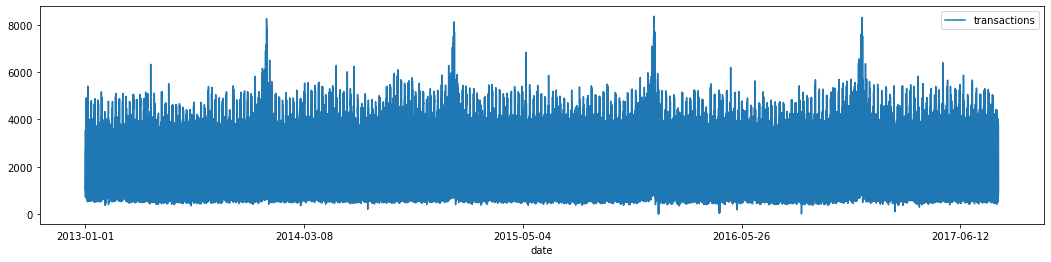

In [23]:
transactions.plot(x='date', y='transactions',figsize=(18,4))

Высокие продажи

In [31]:
trans_high_sales = transactions.query('transactions > 7500')

<AxesSubplot:xlabel='date'>

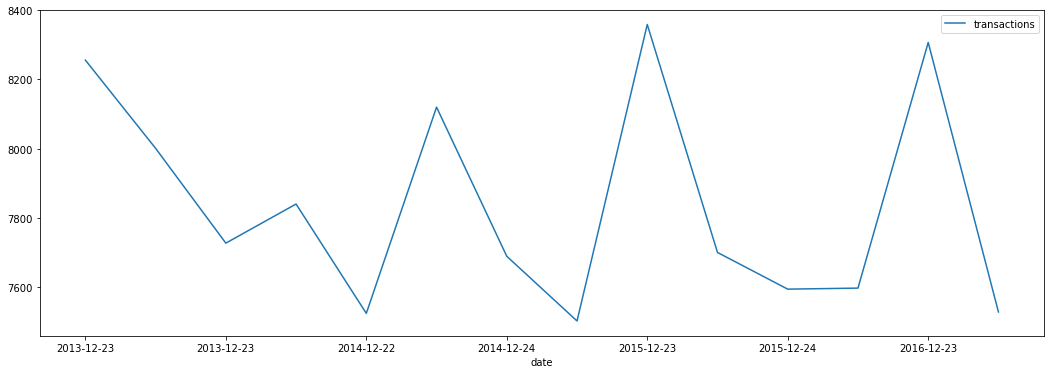

In [32]:
trans_high_sales.plot(x='date', y='transactions',figsize=(18,6))

In [33]:
trans_high_sales

,date,store_nbr,transactions
16570,2013-12-23,44,8256
16572,2013-12-23,46,8001
16573,2013-12-23,47,7727
16619,2013-12-24,46,7840
33652,2014-12-22,44,7524
33700,2014-12-23,44,8120
33748,2014-12-24,44,7689
51958,2015-12-22,44,7502
52011,2015-12-23,44,8359
52064,2015-12-24,44,7700


In [35]:
trans_high_sales.transactions.max()

8359

Общая продажа для каждого магазина

In [41]:
store_totals = transactions.groupby("store_nbr", as_index=False).sum().sort_values('transactions', ascending=False)
store_totals.head(10)

,store_nbr,transactions
43,44,7273093
46,47,6535810
44,45,6201115
45,46,5990113
2,3,5366350
47,48,5107785
7,8,4637971
48,49,4574103
49,50,4384444
10,11,3972488


In [42]:
store_totals.loc[store_totals['transactions']<1000000]

,store_nbr,transactions
28,29,981448
20,21,842891
41,42,802646
21,22,504156
51,52,275393


In [46]:
store_totals.transactions.sum()

141478945

In [47]:
store1 = transactions.query('store_nbr == 1')
store1

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83218,2017-08-11,1,570
83272,2017-08-12,1,1004
83326,2017-08-13,1,416
83380,2017-08-14,1,1733


In [48]:
transactions.store_nbr.max()

54

In [51]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [56]:
stores_and_trans  =  stores.merge(store_totals, on = 'store_nbr')

In [58]:
stores_and_trans.head()

,store_nbr,city,state,type,cluster,transactions
0,1,Quito,Pichincha,D,13,2553963
1,2,Quito,Pichincha,D,13,3219901
2,3,Quito,Pichincha,D,8,5366350
3,4,Quito,Pichincha,D,9,2519007
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,2347877


In [61]:
stores_and_trans.cluster.value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

Какие кластеры показали лучшие результаты

In [72]:
stores_and_trans.groupby('cluster', as_index=False).sum().set_index('cluster')

,store_nbr,transactions
cluster,,
1,76,7574255
2,79,3284365
3,240,10200231
4,84,6979075
5,44,7273093
6,134,16007580
7,36,2792006
8,18,13000314
9,27,4307178


In [137]:
stores_and_trans.set_index('store_nbr').head()

,city,state,type,cluster,transactions
store_nbr,,,,,
1,Quito,Pichincha,D,13,2553963
2,Quito,Pichincha,D,13,3219901
3,Quito,Pichincha,D,8,5366350
4,Quito,Pichincha,D,9,2519007
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,2347877


In [76]:
stores_and_trans.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

кластеры с наибольшим количеством транзакций

In [78]:
stores_and_trans.sort_values('transactions', ascending=False).head(4)

,store_nbr,city,state,type,cluster,transactions
43,44,Quito,Pichincha,A,5,7273093
46,47,Quito,Pichincha,A,14,6535810
44,45,Quito,Pichincha,A,11,6201115
45,46,Quito,Pichincha,A,14,5990113


Разделим данные по type

In [104]:
df_type_data = stores_and_trans.groupby('type', as_index=False) \
    .agg({'transactions': 'sum'}) \
    .rename(columns={'type': 'store_type'})
df_type_data

,store_type,transactions
0,A,43215470
1,B,20384902
2,C,24788958
3,D,46230088
4,E,6859527


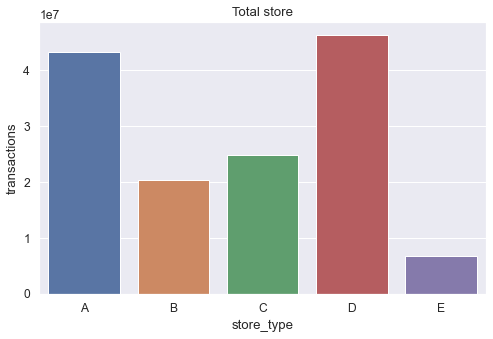

In [136]:
plt.figure(figsize = (8, 5))
sns.set(font_scale = 1.1)
categories = df_type_data
plt.title('Total store')
ax = sns.barplot(y=categories.transactions, x=categories.store_type)
plt.show()

In [123]:
df_type_a['transactions'].describe()

count    9.000000e+00
mean     4.801719e+06
std      2.150877e+06
min      2.753930e+05
25%      4.384444e+06
50%      5.107785e+06
75%      6.201115e+06
max      7.273093e+06
Name: transactions, dtype: float64

In [111]:
stores_and_trans['cluster'].value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

In [112]:
df_cluster_trans = stores_and_trans.groupby('cluster', as_index=False) \
    .agg({'transactions': 'sum'}) \
    .rename(columns={'cluster': 'store_cluster'})

df_cluster_trans

,store_cluster,transactions
0,1,7574255
1,2,3284365
2,3,10200231
3,4,6979075
4,5,7273093
5,6,16007580
6,7,2792006
7,8,13000314
8,9,4307178
9,10,10230630


In [114]:
df_cluster_trans.transactions.describe()

count    1.700000e+01
mean     8.322291e+06
std      5.408581e+06
min      2.071278e+06
25%      3.284365e+06
50%      7.574255e+06
75%      1.023063e+07
max      2.201815e+07
Name: transactions, dtype: float64

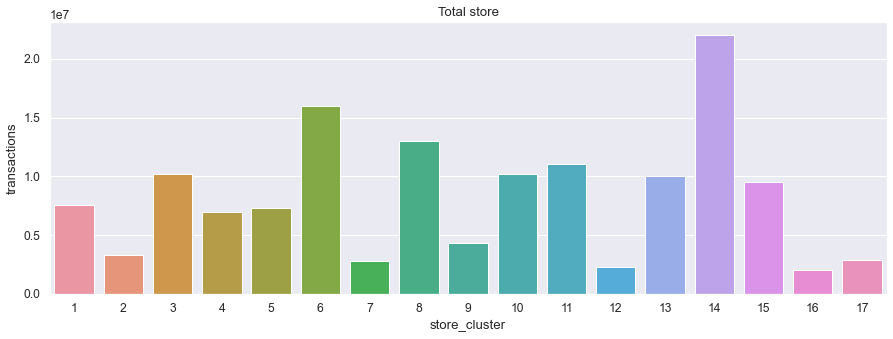

In [120]:
plt.figure(figsize = (15, 5))
sns.set(font_scale = 1.1)
categories = df_cluster_trans
plt.title('Total store')
ax = sns.barplot(y=categories.transactions, x=categories.store_cluster)
plt.show()

In [126]:
transactions['year'] = transactions.date.apply(lambda x: x.split('-')[0])

transactions

,date,store_nbr,transactions,year
0,2013-01-01,25,770,2013
1,2013-01-02,1,2111,2013
2,2013-01-02,2,2358,2013
3,2013-01-02,3,3487,2013
4,2013-01-02,4,1922,2013
...,...,...,...,...
83483,2017-08-15,50,2804,2017
83484,2017-08-15,51,1573,2017
83485,2017-08-15,52,2255,2017
83486,2017-08-15,53,932,2017


In [130]:
df_trans_yearly = transactions.groupby('year', as_index=False) \
    .agg({'transactions': 'sum'})

df_trans_yearly

,year,transactions
0,2013,29107173
1,2014,30006929
2,2015,31312370
3,2016,31052337
4,2017,20000136


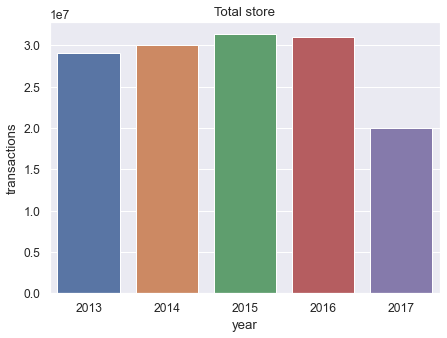

In [135]:
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.1)
categories = df_trans_yearly
plt.title('Total store')
ax = sns.barplot(y=categories.transactions, x=categories.year)
plt.show()